In [1]:
from coniferest.isoforest import IsolationForest
from coniferest.pineforest import PineForest
from coniferest.aadforest import AADForest
from coniferest.label import Label
from coniferest.session import Session
from coniferest.session.callback import (
    TerminateAfter, prompt_decision_callback,
)

import pandas as pd
from pandas.api.types import is_float_dtype
import numpy as np
import matplotlib.pylab as plt
from progressbar import progressbar
from itertools import repeat
from concurrent.futures import ProcessPoolExecutor

## Data

In [2]:
path = '/media/snad/data/deviation-network/dataset/UNSW_NB15_traintest_backdoor.tar.xz'
data = pd.read_csv(path)

In [3]:
np.unique(data['class'].values, return_counts=True)

(array([0, 1]), array([93000,  2329]))

In [4]:
# percentage of anomalies
tag, freq = np.unique(data['class'].values, return_counts=True)
print('Percentage of anomalies = ', np.round(100*freq[1]/freq[0], 3), '%')

Percentage of anomalies =  2.504 %


In [5]:
# get columns which are all floats + the class tag
float_cols = [c for c in data.columns if is_float_dtype(data[c])] + ['class']
data2 = data[float_cols]

In [6]:
# remove columns of anomaly tag
data_use = data2[list(data2.keys()[:-1])]

In [7]:
data_use.shape

(95329, 38)

In [8]:
# check if all elements are floats
all_floats = data_use.dtypes.apply(lambda x: x.kind == "f").all()
print(all_floats)

True


## Isolation Forest

In [9]:
# fit a normal Isolation forest
model_if = IsolationForest(random_seed=42)
model_if.fit(data_use.values)

In [10]:
scores_if = model_if.score_samples(data_use.values)

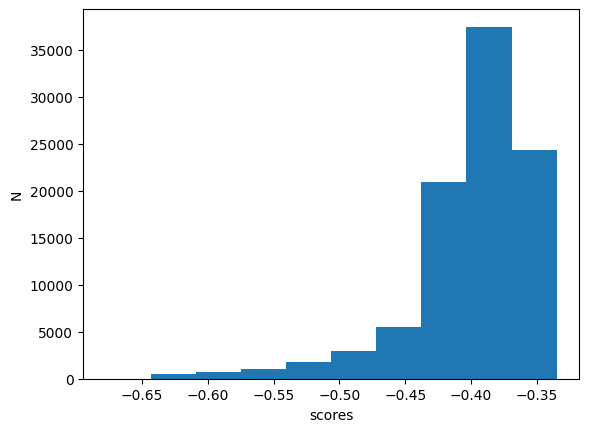

In [11]:
plt.hist(scores_if)
plt.xlabel('scores')
plt.ylabel('N')
plt.show()

In [14]:
# get the 100 most anomalous objects
order_if = np.argsort(scores_if)

In [20]:
nloops = 500

In [21]:
# get labels for 100 most anomalous objects
labels_if = data['class'].values[order_if[:nloops]]

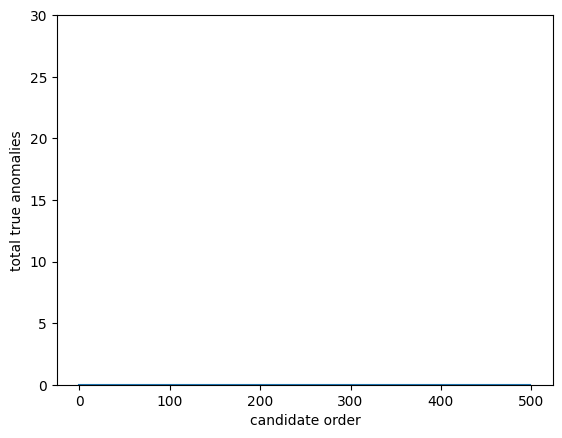

In [22]:
# plot the result in order

y_if = [sum(labels_if[:i]) for i in range(len(labels_if))]
x = np.arange(len(labels_if))

plt.figure()
plt.plot(x,y_if)
plt.xlabel('candidate order')
plt.ylabel('total true anomalies')
plt.ylim(0,30)
plt.show()

In [23]:
# run 200 in a role
n = 200

In [24]:
y_if_all = []

for i in progressbar(range(n)):
    model_temp_if = IsolationForest(random_seed=np.random.randint(10**9))
    model_temp_if.fit(data_use.values)
    scores_temp_if = model_temp_if.score_samples(data_use.values)
    order_temp_if = np.argsort(scores_temp_if)
    labels_temp_if = data['class'].values[order_temp_if[:nloops]]
    y_temp_if = [sum(labels_temp_if[:i]) for i in range(len(labels_temp_if))]
    y_if_all.append(y_temp_if)

100% (200 of 200) |######################| Elapsed Time: 0:00:44 Time:  0:00:440003


In [25]:
y_if_all = np.array(y_if_all)

In [26]:
np.save("../data/isoforest_backdoor_" + str(n) + "runs.npy", y_if_all)

In [27]:
y_if_all = np.load("../data/isoforest_backdoor_" + str(n) + "runs.npy")

In [28]:
# get numbers for plotting
ymax_if = [np.percentile(y_if_all[:,i],95) for i in range(y_if_all.shape[1])]
ymin_if = [np.percentile(y_if_all[:,i], 5) for i in range(y_if_all.shape[1])]
ymedian_if = [np.median(y_if_all[:,i]) for i in range(y_if_all.shape[1])]

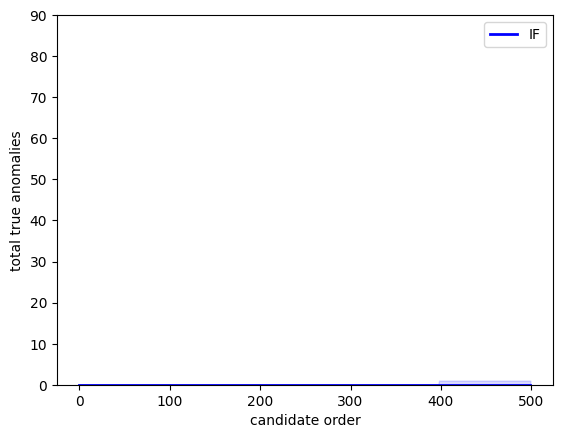

In [29]:
# plot intervals

plt.figure()
ax = plt.subplot(1,1,1)
ax.plot(x, ymedian_if, color='blue', lw=2, label='IF')
ax.fill_between(x, ymin_if, ymax_if, color='blue', alpha=0.15)
plt.xlabel('candidate order')
plt.ylabel('total true anomalies')
plt.ylim(0,90)
plt.legend()
plt.show()

## PineForest

In [30]:
# set up to use already known labels
def my_on_refit_callback(session):
    #print('Refitting model with known labels:')
    #print(session.known_labels)
    return None

def my_decision_callback(metadata, data, session):
    """Get data from the known table."""
    return Label.ANOMALY if metadata[0] else Label.REGULAR

def my_on_decision_callback(metadata, data, session):
    #print(f'Decision made for {metadata}: {session.last_decision}.')
    return None

class RecordCallback:
    def __init__(self):
        self.records = []

    def __call__(self, metadata, data, session):
        self.records.append(f'{metadata} -> {session.last_decision}')

    def print_report(self):
        #print('Records:')
        #print('\n'.join(self.records))
        return None

In [32]:
record_callback_pine = RecordCallback()

metadata = data.values[:,-1:]
model_pine = PineForest(random_seed=42)
nloops = 500           # number of loops 

In [33]:
session_pine = Session(
    data=data_use.values,
    metadata=metadata,
    model=model_pine,
    decision_callback=my_decision_callback,
    # We can give an only function/callable as a callback
    on_refit_callbacks=my_on_refit_callback,
    # Or a list of callables
    on_decision_callbacks=[
        my_on_decision_callback,
        record_callback_pine,
        TerminateAfter(nloops),
    ],
)
session_pine.run()

In [34]:
labels_pine = [list(session_pine.known_labels.values())[i] == Label.ANOMALY for i in range(nloops)]

In [35]:
y_pine = [sum(labels_pine[:i]) for i in range(len(labels_pine))]

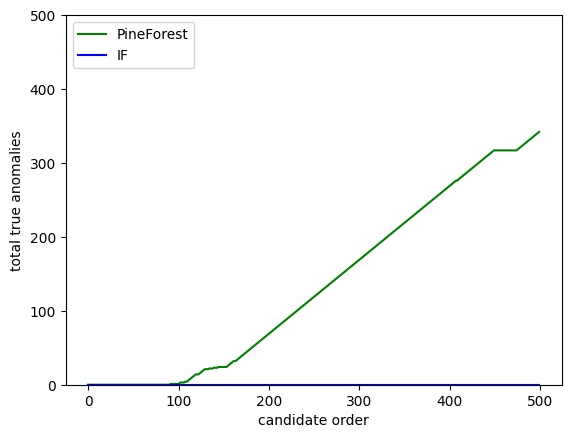

In [57]:
# plot 1 instance

plt.figure()
plt.plot(x, y_pine, color='green', label='PineForest')
plt.plot(x, y_if, color='blue', label='IF')
plt.xlabel('candidate order')
plt.ylabel('total true anomalies')
plt.ylim(0,500)
plt.legend(loc='upper left')
plt.show()

In [37]:
# do it 200 times
n_cores = 20

def pineforest_run(data, metadata, seed):
    """Train, evaluate and save results from the model."""
    
    model_temp_pine = PineForest(random_seed=seed, n_jobs=1)  
    record_callback_temp_pine = RecordCallback()

    session_temp_pine = Session(
        data=data.values,
        metadata=metadata,
        model=model_temp_pine,
        decision_callback=my_decision_callback,
        # We can give an only function/callable as a callback
        on_refit_callbacks=my_on_refit_callback,
        # Or a list of callables
        on_decision_callbacks=[
            my_on_decision_callback,
            record_callback_temp_pine,
            TerminateAfter(nloops),
        ],
    )
    session_temp_pine.run()
    labels_temp_pine = [list(session_temp_pine.known_labels.values())[i] == Label.ANOMALY 
                        for i in range(nloops)]
    y_temp_pine = [sum(labels_temp_pine[:i]) for i in range(len(labels_temp_pine))]

    return y_temp_pine

result =[]
seeds = [np.random.randint(10**9) for i in range(n)]

with ProcessPoolExecutor(max_workers=n_cores) as exe:
    exe.submit(pineforest_run, data_use, metadata)
        
    # Maps the realization with a iterable
    result = list(exe.map(pineforest_run, repeat(data_use), repeat(metadata), seeds))


In [38]:
y_pine_all = np.array(result)

In [39]:
# save to file
np.save("../data/pineforest_backdoor_" + str(n) + "runs.npy", y_pine_all)

In [40]:
y_pine_all = np.load('../data/pineforest_backdoor_' + str(n) + 'runs.npy')

In [41]:
# get numbers for plotting
ymax_pine = [np.percentile(y_pine_all[:,i],95) for i in range(y_pine_all.shape[1])]
ymin_pine = [np.percentile(y_pine_all[:,i], 5) for i in range(y_pine_all.shape[1])]
ymedian_pine = [np.median(y_pine_all[:,i]) for i in range(y_pine_all.shape[1])]

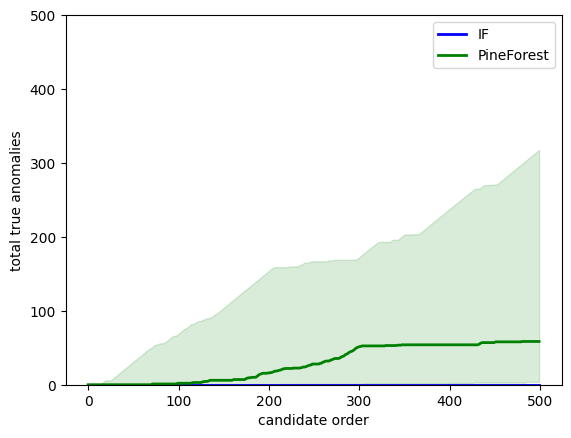

In [56]:
# plot intervals

plt.figure()
ax = plt.subplot(1,1,1)
ax.plot(x, ymedian_if, color='blue', lw=2, label='IF')
ax.plot(x, ymedian_pine, color='green', lw=2, label='PineForest')
ax.fill_between(x, ymin_if, ymax_if, color='blue', alpha=0.15)
ax.fill_between(x, ymin_pine, ymax_pine, color='green', alpha=0.15)
plt.xlabel('candidate order')
plt.ylabel('total true anomalies')
plt.ylim(0,500)
plt.legend()
plt.show()

## AAD

In [43]:
record_callback_aad = RecordCallback()

model_aad = AADForest(random_seed=42)

session_aad = Session(
    data=data_use.values,
    metadata=metadata,
    model=model_aad,
    decision_callback=my_decision_callback,
    # We can give an only function/callable as a callback
    on_refit_callbacks=my_on_refit_callback,
    # Or a list of callables
    on_decision_callbacks=[
        my_on_decision_callback,
        record_callback_aad,
        TerminateAfter(nloops),
    ],
)
session_aad.run()

In [44]:
labels_aad = [list(session_aad.known_labels.values())[i] == Label.ANOMALY for i in range(nloops)]

In [45]:
y_aad = [sum(labels_aad[:i]) for i in range(len(labels_aad))]

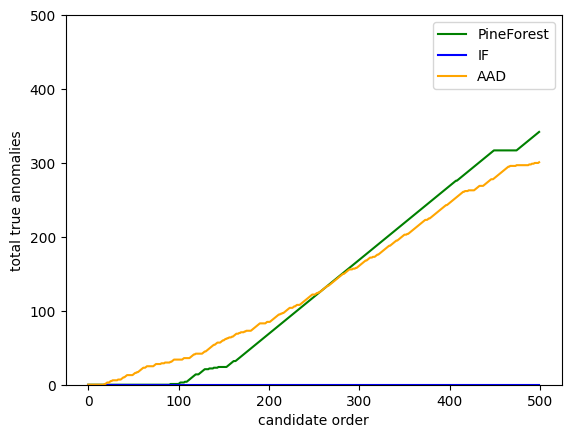

In [55]:
# plot 1 instance

plt.figure()
plt.plot(x, y_pine, color='green', label='PineForest')
plt.plot(x, y_if, color='blue', label='IF')
plt.plot(x, y_aad, color='orange', label='AAD')
plt.xlabel('candidate order')
plt.ylabel('total true anomalies')
plt.ylim(0,500)
plt.legend()
plt.show()

In [47]:
def aad_run(data, metadata, seed):
    """Train, evaluate and save results from the model."""
    
    model_temp_aad = AADForest(random_seed=seed, n_jobs=1)  
    record_callback_temp_aad = RecordCallback()

    session_temp_aad = Session(
        data=data.values,
        metadata=metadata,
        model=model_temp_aad,
        decision_callback=my_decision_callback,
        # We can give an only function/callable as a callback
        on_refit_callbacks=my_on_refit_callback,
        # Or a list of callables
        on_decision_callbacks=[
            my_on_decision_callback,
            record_callback_temp_aad,
            TerminateAfter(nloops),
        ],
    )
    session_temp_aad.run()
    labels_temp_aad = [list(session_temp_aad.known_labels.values())[i] == Label.ANOMALY 
                        for i in range(nloops)]
    y_temp_aad = [sum(labels_temp_aad[:i]) for i in range(len(labels_temp_aad))]

    return y_temp_aad


In [48]:
result =[]
seeds = [np.random.randint(10**9) for i in range(n)]

with ProcessPoolExecutor(max_workers=n_cores) as exe:
    exe.submit(aad_run, data_use, metadata)
        
    # Maps the realization with a iterable
    result = list(exe.map(aad_run, repeat(data_use), repeat(metadata), seeds))

y_aad_all = np.array(result)


In [49]:
# save to file
np.save("../data/aad_backdoor_" + str(n) + "runs.npy", y_aad_all)

In [50]:
y_aad_all = np.load('../data/aad_backdoor_' + str(n) + 'runs.npy')

In [51]:
# get numbers for plotting
ymax_aad = [np.percentile(y_aad_all[:,i],95) for i in range(y_aad_all.shape[1])]
ymin_aad = [np.percentile(y_aad_all[:,i], 5) for i in range(y_aad_all.shape[1])]
ymedian_aad = [np.median(y_aad_all[:,i]) for i in range(y_aad_all.shape[1])]

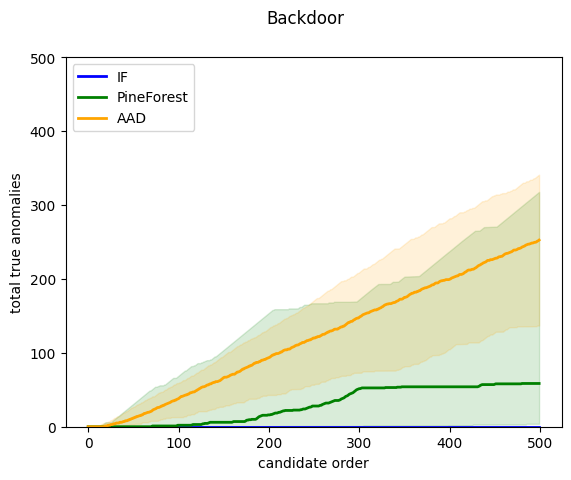

In [54]:
# plot intervals

plt.figure()
plt.suptitle('Backdoor')
ax = plt.subplot(1,1,1)
ax.plot(x, ymedian_if, color='blue', lw=2, label='IF')
ax.plot(x, ymedian_pine, color='green', lw=2, label='PineForest')
ax.plot(x, ymedian_aad, color='orange', lw=2, label='AAD')
ax.fill_between(x, ymin_if, ymax_if, color='blue', alpha=0.15)
ax.fill_between(x, ymin_pine, ymax_pine, color='green', alpha=0.15)
ax.fill_between(x, ymin_aad, ymax_aad, color='orange', alpha=0.15)
plt.xlabel('candidate order')
plt.ylabel('total true anomalies')
plt.ylim(0,500)
plt.legend(loc='upper left')
plt.show()
#plt.savefig('backdoor.png')